In [1]:
%matplotlib inline
import pymc3 as pm
from theano import shared
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
palette = 'colorblind'
import seaborn as sns; sns.set_palette(palette); sns.set_color_codes(palette)

#### Code 5.1

In [3]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [4]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000)

KeyboardInterrupt: 

In [ ]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.2

In [ ]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'bo')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

##### Code 5.3

In [ ]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [ ]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000)

In [ ]:
pm.traceplot(trace_5_2, varnames);

In [ ]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5);

#### Code 5.4

In [ ]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000)

In [ ]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [ ]:
pm.df_summary(trace_5_3, varnames)

#### Code 5.5

In [ ]:
pm.forestplot(trace_5_3, varnames);

#### Code 5.6

In [ ]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000)

In [ ]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

#### Code 5.7

In [ ]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

#### Code 5.8

In [ ]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

#### Code 5.9

In [ ]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='r', alpha=0.5)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

#### Code 5.10

In [ ]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)


plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='r', alpha=0.5)

plt.xlabel('MedianAgeMarriage.s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

#### Code 5.11

In [ ]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

#### Code 5.12

In [ ]:
mu_hpd = pm.hpd(mu_pred, alpha=0.05)
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='bo')
plt.plot(d.Divorce, divorce_pred.mean(0), 'bo')

plt.xlabel('Observed divorce')
plt.ylabel('Predicted divorce')

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

#### Code 5.14

In [ ]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='bo',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='bo', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

#### Code 5.15

In [ ]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.16

In [ ]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

#### Code 5.17 to 5.20

In [ ]:
dcc = d.dropna().copy()

In [ ]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_5 = pm.sample(1000)

In [ ]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

#### Code 5.21

In [ ]:
pm.df_summary(trace_5_5, varnames).round(3)

#### Code 5.22

In [ ]:
trace_5_5['bn'].mean() * (76 - 55)

#### Code 5.23

In [ ]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'bo')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.24

In [ ]:
dcc['log_mass'] = np.log(dcc['mass'])

#### Code 5.25

In [ ]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000)

In [ ]:
pm.df_summary(trace_5_6, varnames).round(2)

#### Code 5.26

In [ ]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000)

In [ ]:
pm.df_summary(trace_5_7, varnames).round(2)

#### Code 5.27

In [ ]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['a'] + trace_5_7['bn'][:,0] * seq[:,None] + trace_5_7['bn'][:,1] * dcc['log_mass'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.28

In [ ]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [41]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
d = pd.DataFrame([height,leg_left,leg_right])
d

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,9.329942,8.498548,14.935436,6.961606,11.115655,11.395802,12.685236,10.553086,10.918288,13.296186,...,11.688370,7.312068,8.209179,11.537916,8.799667,13.093949,5.937641,10.885363,10.007689,12.108363
1,3.819965,6.389414,7.072452,4.354435,6.402087,7.161194,6.555032,5.611480,6.491866,6.305832,...,6.637625,4.622480,7.399314,5.814597,5.053513,11.377588,3.733777,8.923750,7.500619,9.719570
2,3.843697,6.447179,7.103885,4.346113,6.411151,7.153578,6.516215,5.637915,6.527660,6.316526,...,6.656013,4.611924,7.372118,5.840043,5.027270,11.335208,3.688623,8.945948,7.534947,9.742194


#### Code 5.30

In [145]:
with pm.Model() as m5_8:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    br = pm.Normal('br',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=d)
    trace_5_8 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bl
Assigned NUTS to br
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 36.6 sec

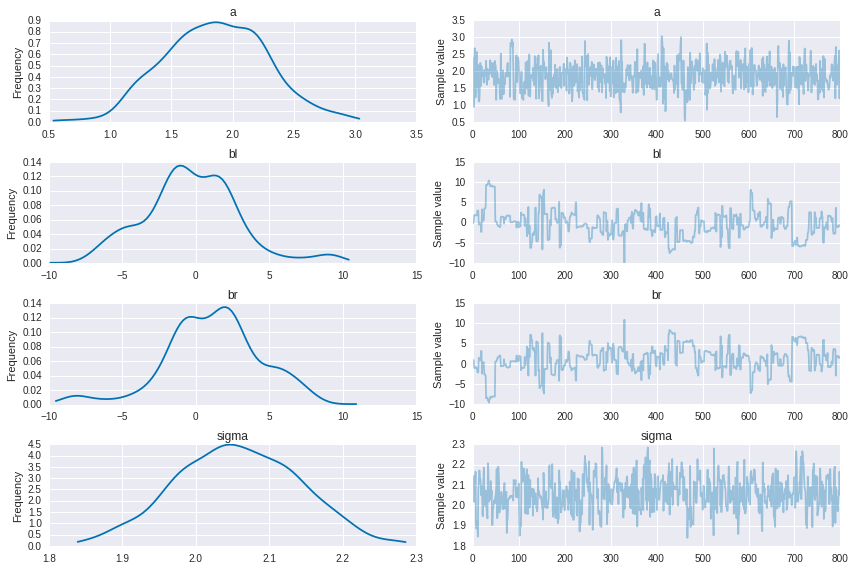

In [155]:
varnames=['a', 'bl', 'br', 'sigma']
chain=trace_5_8[200:]
pm.traceplot(chain, varnames);

#### Code 5.31

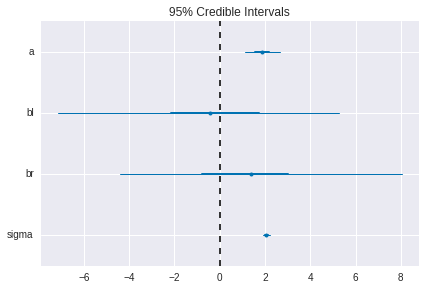

In [147]:
pm.forestplot(chain, varnames);

#### Code 5.32

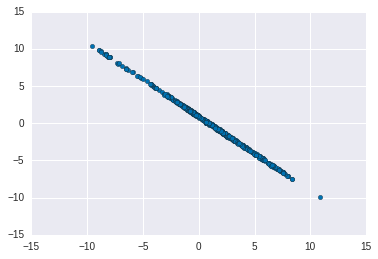

In [148]:
plt.scatter(chain['br'], chain['bl']);

#### Code 5.33

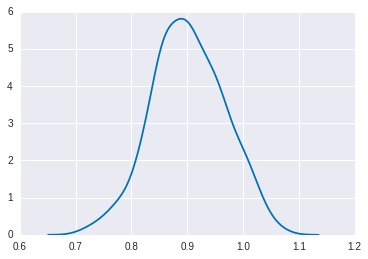

In [149]:
sum_blbr = chain['br']+chain['bl']
sns.kdeplot(sum_blbr);

#### Code 5.34

In [150]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=d)
    trace_5_9 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bl
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 2.8 sec

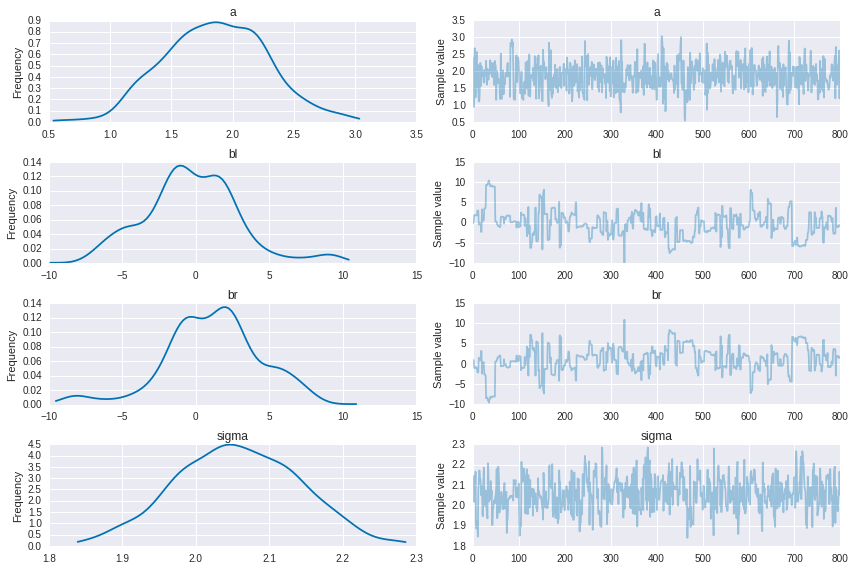

In [156]:
chain_1 = trace_5_9[200:]
varnames_1= ['bl', 'sigma', 'a']
pm.traceplot(chain, varnames);

#### Code 5.35

In [2]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.36

In [195]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bf
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 4.2 sec

In [196]:
varnames=['a', 'bf', 'sigma']
pm.df_summary(trace_5_10, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.300986,0.055183,0.003795,0.215526,0.376590
bf,0.009998,0.001723,0.000135,0.007797,0.012085
sigma,0.087797,0.077078,0.006758,0.059884,0.108683


In [197]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bl
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 6.6 sec

In [198]:
varnames=['a', 'bl', 'sigma']
pm.df_summary(trace_5_11, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,1.160704,0.090214,0.004096,1.045689,1.257148
bl,-0.010497,0.001485,0.000072,-0.012575,-0.008382
sigma,0.085913,0.221700,0.016296,0.048046,0.087391


#### Code 5.37

In [3]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000)

Applied interval-transform to sigma and added transformed sigma_interval to model.
Assigned NUTS to a
Assigned NUTS to bf
Assigned NUTS to bl
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 9.9 sec

In [10]:
varnames=['a', 'bf', 'bl', 'sigma']
chain_5_12 =  trace_5_12[200:]
pm.df_summary(chain_5_12, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.994014,0.236828,0.013706,0.523063,1.440518
bf,0.002076,0.002782,0.000159,-0.002922,0.007874
bl,-0.008519,0.002917,0.000167,-0.014169,-0.002758
sigma,0.068328,0.009128,0.000611,0.054909,0.088650


#### Code 5.38

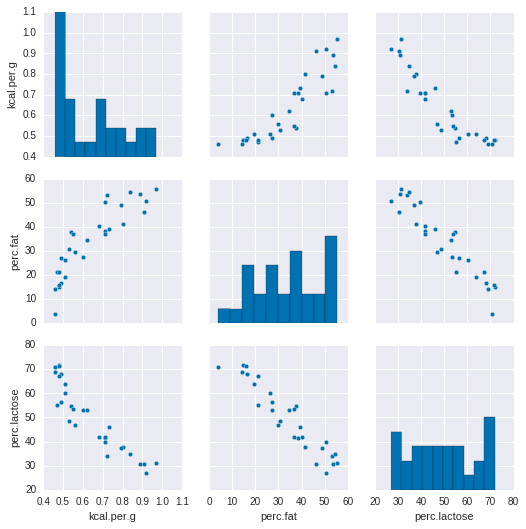

In [19]:
df=milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))